# examples for `hostess.aws.s3`

## introduction

`hostess.aws.s3` is a collection of utilities for working with S3 
objects. Its centerpiece is a class called `Bucket`, which offers
a straightforward interface to a single S3 bucket.

### capabilities

`hostess.aws.s3` is designed as a streamlined alternative to `boto3`'s
high-level S3 API. It is intended to make it easy to integrate S3 
objects into Python workflows without writing a lot of boilerplate. 
It makes read/write operations extremely simple, including reads and 
writes from and to in-memory Python objects.

In addition to simple I/O operations, it offers special functionality 
for several types of tasks that are frequently encountered when working 
with "big data" on S3, but are not straightforward to execute with 
existing tools, specifically:

* building searchable indices of buckets containing many objects
* modifying object storage classes
* writing larger-than-memory or intermittently-streamed data
  to S3 objects

### limitations

`hostess.aws.s3` does not provide interfaces for S3 administrative 
operations, including creating and deleting buckets or managing
object and bucket permissions. If you need to perform automated S3 
admin tasks of this type, you will need to supplement `hostess` with 
`boto3` or interface to the S3 API. (`hostess.aws` does offer some 
generic utilities to make using `boto3` easier.) `hostess` may expand
its S3 administrative capabilities in the future.

`hostess.aws.s3` is not principally intended for bulk data transfer,
and does not offer any special optimizations for reading or writing 
large numbers of objects at once. It _can_ be easily used in parallelized 
operations on large numbers of objects, and it may include some managed
functionality for this in the future; it is reasonably appropriate for 
these purposes when used in this fashion. For most bulk transfer
operations between filesystems and S3, however, we recommend using a 
Filesystem in Userspace (FUSE) interface to S3 such as 
[Goofys](https://github.com/kahing/goofys) or 
[s3fs](https://github.com/s3fs-fuse/s3fs-fuse). FUSE interfaces allow 
you to treat S3 objects much like local files, and generally include 
automated parallelism and caching. We do not recommend `boto3` for this 
purpose; it shares all of `hostess`'s deficiencies. The AWS CLI is
a reasonable alternative, but considerably more awkward than FUSE.

### requirements

1. If you have no valid AWS credentials, `hostess.aws` (like any other AWS 
interface) will not function. By default, `hostess` uses the 'default' 
profile from ~/.aws/credentials. This can be modified in 
`hostess.config.user_config` or by manually constructing a `boto3` session 
or client with `init_session` or `init_client` from `hostess.aws.utilities`.

2. You need appropriate AWS permissions -- including permissions for the specific
S3 resources you wish to access -- in order to use `hostess.aws.s3`. You cannot,
for instance, use `Bucket.ls()` without the ListObjectsV2 permission, or use
`Bucket.put()` without the PutObject permission. (A complete discussion of AWS
permissions management is beyond the scope of this document. See 
[this document](https://docs.aws.amazon.com/AmazonS3/latest/userguide/access-policy-language-overview.html) 
for an overview of S3 permissions.)

If you are having trouble accessing an S3 resource via `hostess` and are unsure 
whether permissions, account access, resource name, or network issues are at fault, 
try calling `hostess.aws.utils.whoami()`. This function performs an API call that 
is *always* available to any AWS account, even if an administrator has specifically 
tried to deny it (the 
[STS GetCallerIdentity action](https://docs.aws.amazon.com/STS/latest/APIReference/API_GetCallerIdentity.html)). 
If it fails, either there is something wrong with your credentials, or some network 
issue is preventing you from accessing AWS API endpoints.

### general s3 notes and vocab

As one more preliminary, we'd like to make a few quick notes about S3. These 
notes aren't specific to `hostess`. They're statements about S3 in general.

S3 objects are designed to look a lot like files, S3 buckets
are designed to look a lot like filesystems, and in many cases, they 
can be used like files and filesystems. They aren't, though,
and we prefer to use precise vocabulary to emphasize the differences.

The full name of an S3 object is called its _object key name_ or just _key_. 
This includes its full 'path' in addition to its 'file name'. The components of the
'path' prior to the 'file name' are called _prefixes_. Prefixes are loosely
analogous to directories in a filesystem, and interfaces often
display them as if they were. However, prefixes are not actually directories,
and a key is not actually a path. Directories are a type of file, but 
prefixes are just 
["a string of characters at the beginning of the object key name"](https://docs.aws.amazon.com/AmazonS3/latest/userguide/using-prefixes.html) that can be used to help organize objects and permissions. 
They are not AWS resources in and of themselves. They cannot be 
renamed/moved, given AWS resource tags, or otherwise directly manipulated.

Similarly, unlike files, S3 objects also cannot be renamed / moved. "Moving" an
S3 object always means making a complete copy of it with a different key
and subsequently deleting the original, even if the new copy is in the 
same "filesystem" (bucket). It is no slower to copy an object
from one bucket to another than to copy an object within the same
bucket (unless the buckets are in different AWS Regions).

Finally, unlike files, S3 objects are immutable. Although it is possible to read
just a portion of an S3 object, it is not possible to perform incremental
writes to an S3 object. Anything that looks like a tail-write to an S3
object actually overwrites the whole object with a slightly modified
copy of itself. This tends to be horribly inefficient. Multipart uploads
provide the closest approximation to 'real' tail-writes, and they don't
actually create accessible objects until they're completed.

----

## make an example bucket

This isn't a showcase of `hostess`'s capabilities -- it just uses `boto3`
and the Python Standard Library -- but it's a necessary 
precursor to the subsequent examples. If you have an existing empty bucket 
you'd like to use, you can skip this section, and if you've already run 
through this section before, you can reuse the bucket you made.

AWS bucket names have to be unique within an AWS Partition (grouping of
Regions), so we'll make a bucket with a random name. If you'd like to
reuse this bucket later, make sure you note down or can easily look up 
the name (like in the AWS Web Console).

In [13]:
from random import randint
from hostess.aws.utilities import init_client

bucket_name = f"hostess-{''.join(str(randint(0, 9)) for _ in range(9))}"
response = init_client('s3').create_bucket(Bucket=bucket_name)
if response['ResponseMetadata']['HTTPStatusCode'] == 200:
    print("We're ready to continue.")
    print(f"The bucket name is {bucket_name}.")
else:
    print("Something went wrong. Take a look at the response.")

we're ready to continue.
the bucket name is hostess-77653009.


## reading, writing, and indexing cat pictures

We'll populate our example bucket with cat pictures and use them to demonstrate
some basic features of `Bucket`.

### download cat pictures

First, let's grab some cat pictures to write to our example bucket from the
Cat as a Service API. This should take about 20 seconds, depending
on internet weather.

In [39]:
from collections import defaultdict
from io import BytesIO
import requests

# feline binary array hash
cat_hash = defaultdict(list)

for adjective in ("cute", "angry", "white", "black", "tabby"):
    print(f"fetching pictures of {adjective} cats...")
    for _ in range(5):
        # get data for a cat picture
        cat_blob = requests.get(f"https://cataas.com/cat/{adjective}").content
        # write it into a filelike object and put it in the cat hash
        cat_hash[adjective].append(BytesIO(cat_blob))
print("done.")

fetching pictures of cute cats...
fetching pictures of angry cats...
fetching pictures of white cats...
fetching pictures of black cats...
fetching pictures of tabby cats...
done.


### write cat pictures to the bucket

`hostess.aws.s3.Bucket` can deal with both local files and in-memory objects.
We currently have a wealth of cat pictures in memory, so let's start with
those.

In [40]:
from hostess.aws.s3 import Bucket

# initialize a Bucket object connected to our example bucket
bucket = Bucket(bucket_name)  # so difficult!

# write the cat pictures to adjectival prefixes. because 
# we don't have unique filenames for these, we'll just
# give them key names corresponding to adjective and index.
# note that we're using the adjectives as prefixes --
# pseudo-directories -- separating them from the 'file name'
# portion of the object keys with a '/'.
for adjective, cat_blobs in cat_hash.items():
    print(f"uploading pictures of {adjective} cats...") 
    for i, blob in enumerate(cat_blobs):
        bucket.put(blob, f"{adjective}/{adjective}_cat_{i}.jpg")
print("done.")

uploading pictures of cute cats...
uploading pictures of angry cats...
uploading pictures of white cats...
uploading pictures of black cats...
uploading pictures of tabby cats...
done.


### create a manifest of cat pictures

`Bucket` offers a wealth of options for indexing buckets.
One of its most powerful features is its `df` property.
When accessed before populating a `Bucket`'s index, it
immediately indexes the entirety of a bucket's contents
and organizes them into a pandas `DataFrame`.

**CAUTION**: don't call this casually on really, really, big buckets,
especially if you don't care about their entire contents -- it will take 
a long time to complete, and in the worst cases, can even create a
larger-than-memory index. Use `bucket.index_contents`
(explained below) on a single prefix in order to pre-populate the 
`Bucket`'s index in a more controlled way.

In [28]:
## PLACEHOLDER

### read cat pictures from the bucket

`Bucket` can create an S3 object from an in-memory Python
object; it can also create in-memory Python objects from
S3 objects.

`Bucket.get()`'s first argument is the key of the source
object. Its second, optional, argument is the destination
for the download, which can be a path to a local download
destination or a filelike object (like an existing `BytesIO`) 
to write the data into. If you don't pass it, though, it'll 
just give you the data as a new `BytesIO`.

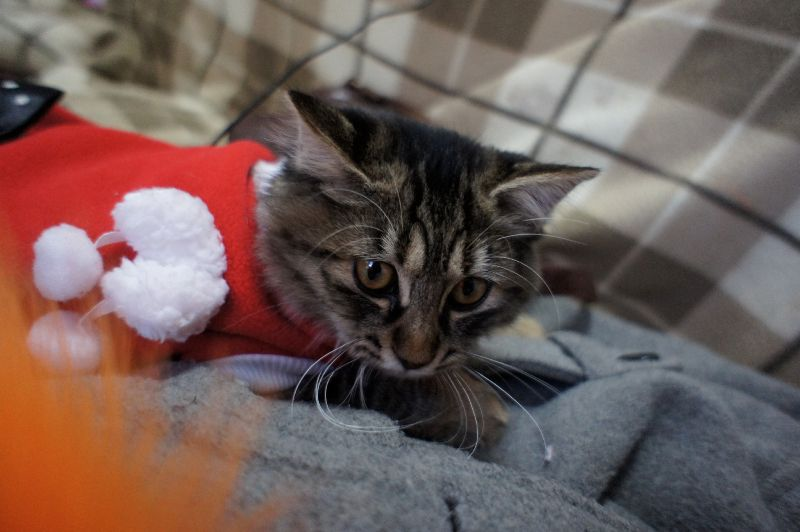

In [52]:
from PIL import Image

# the second return value is the API response metadata, if any.
cat_image_buffer, _ = bucket.get("cute/cute_cat_4.jpg")
Image.open(cat_image_buffer)

## notes

### relationship to `boto3`

`hostess.aws.s3` works primarily as a high-level interface to `boto3`'s low-level S3 API. Due to philosophical differences, it makes almost no use of the `boto3` high-level `Bucket` object, and should be considered a reimagining of that object rather than a wrapper for it. `hostess` `Buckets` do not automatically instantiate or grant access to `boto3` `Buckets`. However, they *do* wrap `boto3` client, resource, and session objects. If users require access to portions of the S3 API not included in `hostess`, they may reference these attributes of a `hostess` `Bucket` in order to perform API calls using the same session/client/resource that underlies the methods of their `hostess` `Bucket`. They may even use them to instantiate a similarly-configured `boto3` `Bucket`, if they would like things to get confusing.